SELECT DISTINCT patient_id, birth_date, genero, accession_number, exame_codigo, exame_desc, exam_datetime FROM `interoper-dataplatform-prd.raw_rdi.rdi_tb_carestream_laudos` 
WHERE exame_desc LIKE '%TORAX%' AND exame_desc LIKE '%INCIDENCIA%' 
AND exam_datetime BETWEEN '2022-01-01' AND '2022-12-31'


In [2]:
from datetime import datetime
from dateutil import relativedelta

import pandas as pd
from tqdm import tqdm
tqdm().pandas()

0it [00:00, ?it/s]


In [3]:
file_csv = 'rx_torax_kaggle.csv'
file_1000 = '1000_bins_processed.csv'
file_1000_acc = '1000_accs_processed.csv'

In [4]:
df = pd.read_csv(file_csv)

In [5]:
def calculate_age(birth_date: str, exam_datetime: str) -> int:
    date_pattern = "%Y-%m-%d %H:%M:%S %Z"
    # convert string to date object
    start_date = datetime.strptime(birth_date, date_pattern)
    end_date = datetime.strptime(exam_datetime, date_pattern)

    # Get the relativedelta between two dates
    delta = relativedelta.relativedelta(end_date, start_date)
    return delta.years

df['age'] = df.progress_apply(lambda row: calculate_age(row['birth_date'], row['exam_datetime']), axis=1)

# keep only >= 18 and <= 99 years olds
df = df[(df['age'] >= 18) & (df['age'] <= 99)]

df['float_age'] = df.age.progress_apply(lambda age: age/10)
df['group_age'] = df.age.progress_apply(lambda age: int(age/10))

100%|██████████████████████████████| 147269/147269 [00:00<00:00, 1683645.90it/s]


In [6]:
df

,patient_id,birth_date,genero,accession_number,exame_codigo,exame_desc,exam_datetime,age,float_age,group_age
0,10170115675,1998-07-22 00:00:00 UTC,F,579410243101TRX2,TRX2HP,TORAX 2 INCIDENCIAS,2022-02-26 05:36:00 UTC,23,2.3,2
1,7670348396,1975-10-05 00:00:00 UTC,F,0003IUQ6P800602T,TRX3GL,TORAX 3 INCIDENCIAS,2022-04-14 16:28:00 UTC,46,4.6,4
2,7676159852,2000-07-20 00:00:00 UTC,F,0003IY6QUK002012,TRX4GL,TORAX 4 INCIDENCIAS,2022-05-03 09:50:00 UTC,21,2.1,2
3,7664479743,1991-02-23 00:00:00 UTC,F,0003IR8EF300B03P,TRX3IM,RX DO TORAX 3 INCIDENCIAS,2022-09-24 15:51:00 UTC,31,3.1,3
4,2200006782,1963-07-03 00:00:00 UTC,F,00010DTS3I039013,TRX3GL,TORAX 3 INCIDENCIAS,2022-11-14 14:56:00 UTC,59,5.9,5
...,...,...,...,...,...,...,...,...,...,...
162519,7662769072,1972-09-19 00:00:00 UTC,F,0003IQ7QGG00J023,RXT2ICIM,RX DO TORAX 2 INCIDENCIAS,2022-05-05 17:52:00 UTC,49,4.9,4
162520,2600024250,1975-07-09 00:00:00 UTC,M,00016ZZJJU00G02V,RXT2ICIM,RX DO TORAX 2 INCIDENCIAS,2022-11-24 07:46:00 UTC,47,4.7,4
162521,7665270292,1957-10-12 00:00:00 UTC,M,0003IRPCES00502Q,RXT2ICIM,RX DO TORAX 2 INCIDENCIAS,2022-03-08 10:29:00 UTC,64,6.4,6
162522,6002820217,1980-11-26 00:00:00 UTC,F,0002R9X9Q101502G,RXT2ICIM,RX DO TORAX 2 INCIDENCIAS,2022-01-06 12:02:00 UTC,41,4.1,4


In [17]:
groupby = ['patient_id', 'age', 'group_age']
df_group = df.groupby(groupby)['accession_number'].max().reset_index()
df_group = df_group.drop_duplicates(subset='patient_id', keep='first')
df_group = df_group.sample(frac=1).reset_index(drop=True)
df_group

,patient_id,age,group_age,accession_number
0,7661012939,63,6,0003IP63EZ00A013
1,7674488113,27,2,0003IX6WXD00801K
2,7663050226,32,3,0003IQDREA00601U
3,6007220082,48,4,0002RCJKOI00B01U
4,7661909844,64,6,0003IPPBH0004018
...,...,...,...,...
143098,7666893442,38,3,0003ISO4UA003048
143099,6169739463,78,7,0002U1AXFR00209G
143100,7660712846,26,2,0003IOZNV20070HL
143101,7677743887,57,5,0003IZ4P3J00102S


In [20]:
assert(df_group['patient_id'].nunique() == len(df_group))

<AxesSubplot: >

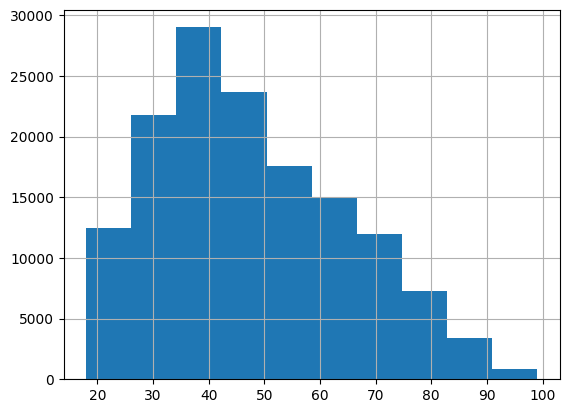

In [23]:
df_group.age.hist()

In [24]:
df_group.group_age.value_counts()

4    32584
3    32171
5    22124
6    18028
2    17860
7    12030
8     5367
1     1831
9     1108
Name: group_age, dtype: int64

In [25]:
df_concat = None
top_n = 1000
for i in range(1, 10):
    df_parcel = df[df.group_age == i].head(top_n)
    if df_concat is None:
        df_concat = df_parcel
    else:
        df_concat = pd.concat([df_parcel, df_concat])
df_concat

,patient_id,birth_date,genero,accession_number,exame_codigo,exame_desc,exam_datetime,age,float_age,group_age
188,91032263,1929-09-25 00:00:00 UTC,F,00001I74XZ01A01Y,TRX3GL,TORAX 3 INCIDENCIAS,2022-04-09 11:16:00 UTC,92,9.2,9
303,7660217968,1926-11-11 00:00:00 UTC,F,0003IOP20G00A12C,TRX3GL,TORAX 3 INCIDENCIAS,2022-09-13 09:19:00 UTC,95,9.5,9
571,6007720284,1932-07-15 00:00:00 UTC,F,0002RCUAN000B01F,TRX3GL,TORAX 3 INCIDENCIAS,2022-08-19 12:37:00 UTC,90,9.0,9
1064,34013819,1929-11-20 00:00:00 UTC,F,00000K918B01101U,TRX3GL,TORAX 3 INCIDENCIAS,2022-02-10 15:32:00 UTC,92,9.2,9
1166,2587392943,1930-06-25 00:00:00 UTC,F,00016SGT6700B03X,TRX3GL,TORAX 3 INCIDENCIAS,2022-01-28 14:18:00 UTC,91,9.1,9
...,...,...,...,...,...,...,...,...,...,...
87250,7662460769,2003-02-08 00:00:00 UTC,F,0003IQ14KH005018,TRX2GL,TORAX 2 INCIDENCIAS,2022-08-27 12:00:00 UTC,19,1.9,1
87273,7677111508,2002-09-18 00:00:00 UTC,M,0003IYR55G00101C,TRX2GL,TORAX 2 INCIDENCIAS,2022-07-19 11:09:00 UTC,19,1.9,1
87274,7676897899,2003-07-24 00:00:00 UTC,F,0003IYMKBV001015,TRX2GL,TORAX 2 INCIDENCIAS,2022-07-30 15:35:00 UTC,19,1.9,1
87414,6175383383,2002-06-24 00:00:00 UTC,F,0002U4NWBB00501Y,TRX2GL,TORAX 2 INCIDENCIAS,2022-05-09 10:37:00 UTC,19,1.9,1


In [27]:
df_concat.patient_id.nunique()

8626

In [26]:
df_concat.group_age.value_counts()

9    1000
8    1000
7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
1    1000
Name: group_age, dtype: int64

In [ ]:
df_concat.to_csv(file_1000, index=False)

print(f'File {file_1000} saved successfully')

File /content/drive/MyDrive/rx_torax_spr/1000_bins_processed_.csv saved successfully


In [ ]:
df_concat['accession_number'].to_csv(file_1000_acc, index=False, header=False)